In [10]:
%matplotlib inline
import os
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import numpy as np

In [12]:
processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")

In [15]:
# Palette de couleurs
color_palette = [
    (0, 0, 0),         # 0 - background (noir)
    (255, 0, 0),       # 1 - haut (rouge)
    (0, 255, 0),       # 2 - bas (vert)
    (0, 0, 255),       # 3 - robe (bleu)
    (255, 255, 0),     # 4 - combinaison (jaune)
    (255, 0, 255),     # 5 - manteau (magenta)
    (0, 255, 255),     # 6 - accessoires (cyan)
    (128, 128, 128),   # 7 - inconnu (gris)
]

# Classes
id2label = {
    0: "Background",
    1: "Upper-clothes",
    2: "Lower-clothes",
    3: "Dress",
    4: "Jumpsuit",
    5: "Coat",
    6: "Accessory",
    7: "Unknown"
}

Processing image_0.png...


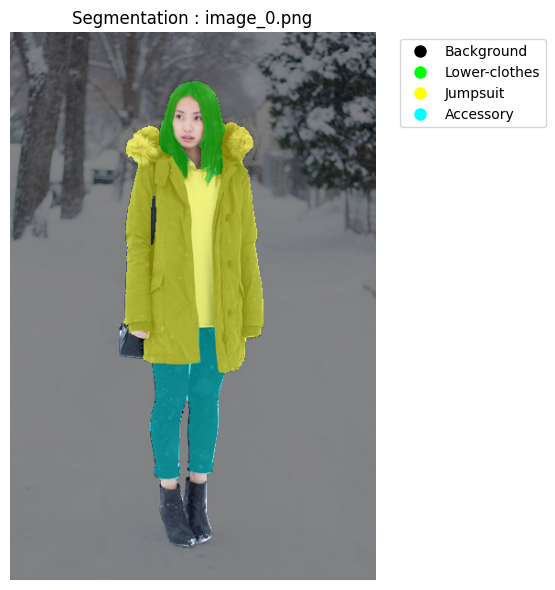

Processing image_1.png...


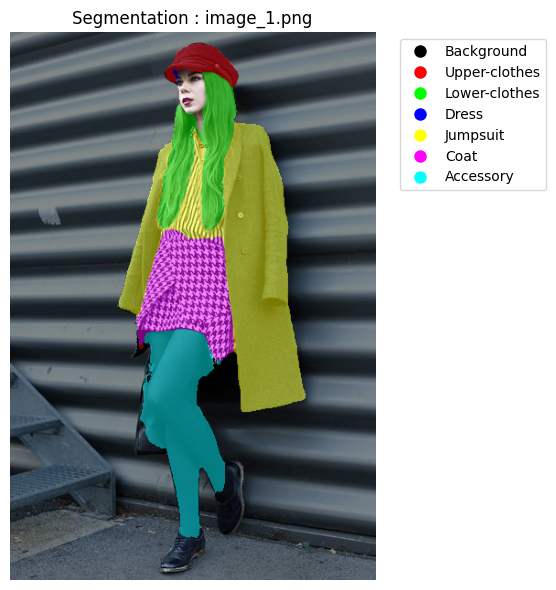

Processing image_10.png...


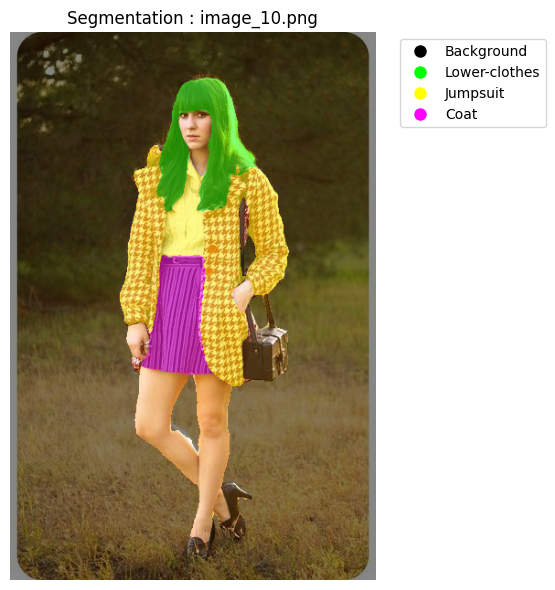

Processing image_11.png...


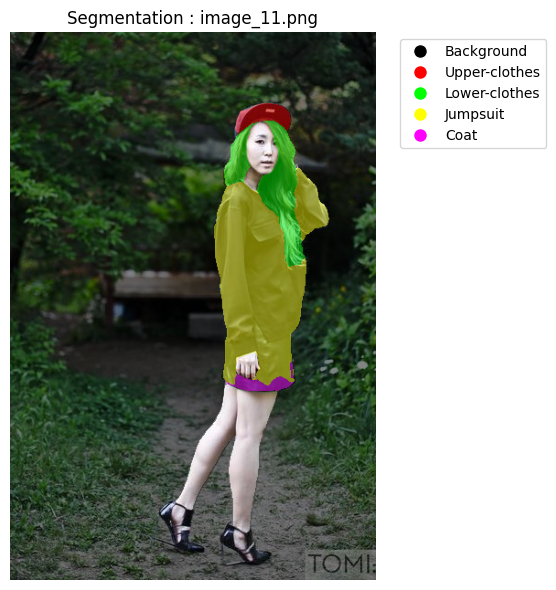

Processing image_12.png...


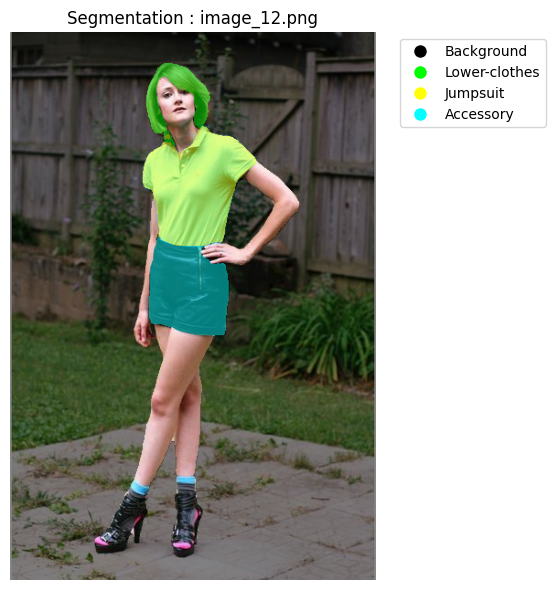

Processing image_13.png...


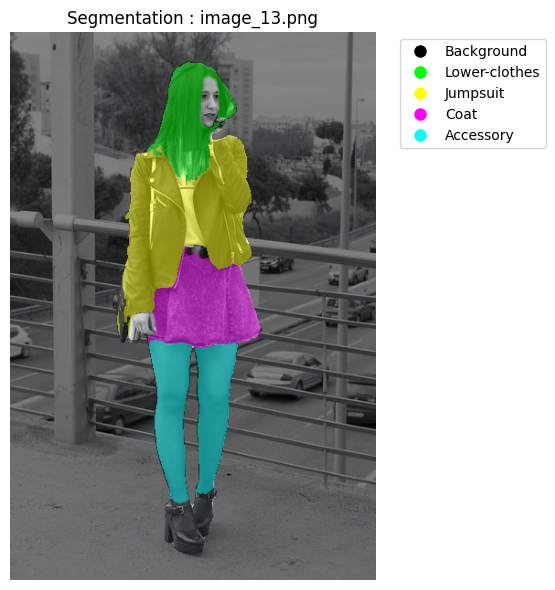

Processing image_14.png...


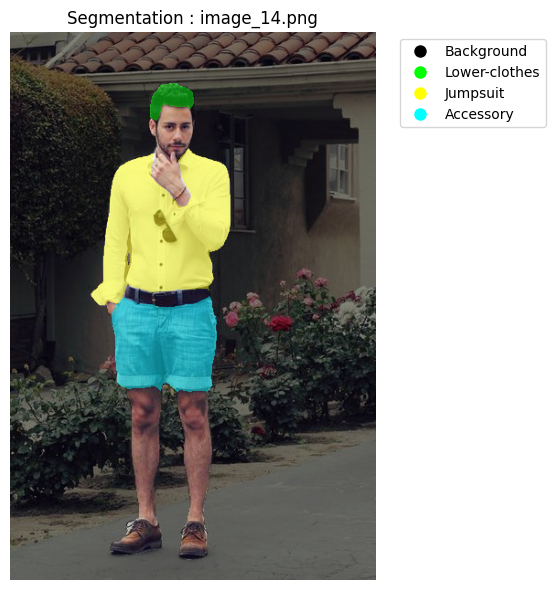

Processing image_15.png...


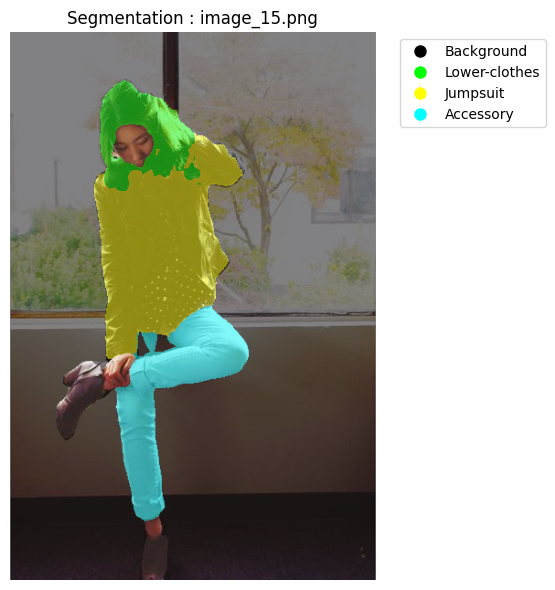

Processing image_16.png...


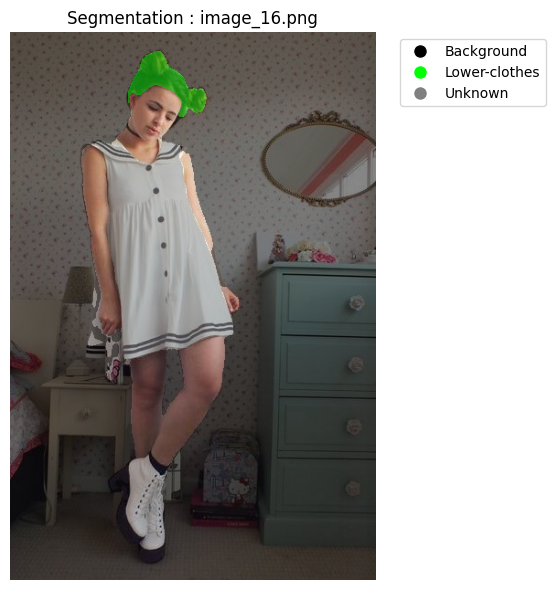

Processing image_17.png...


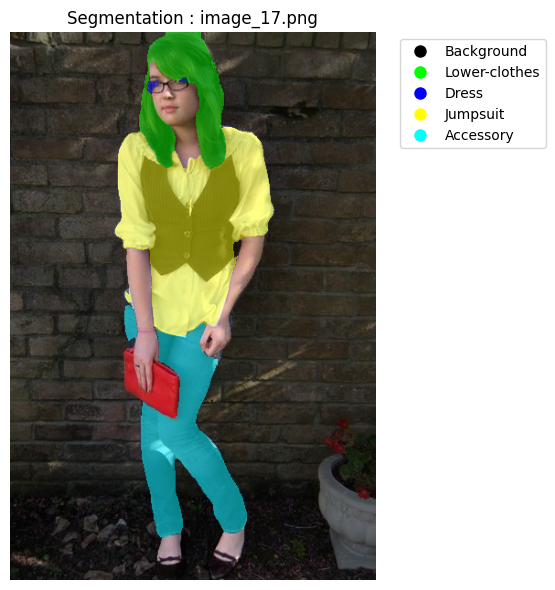

Processing image_18.png...


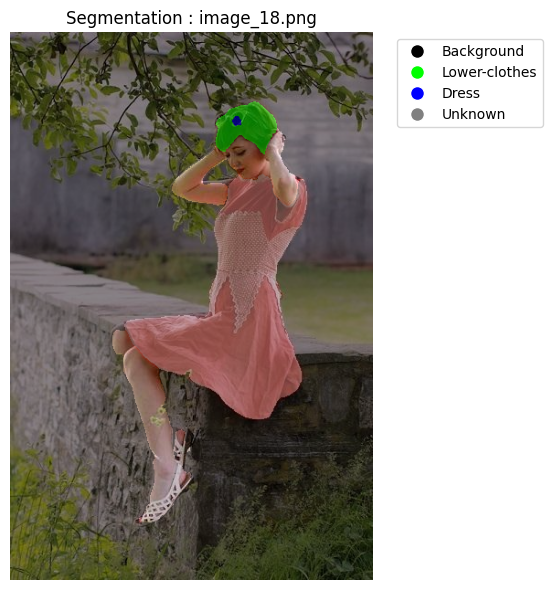

Processing image_19.png...


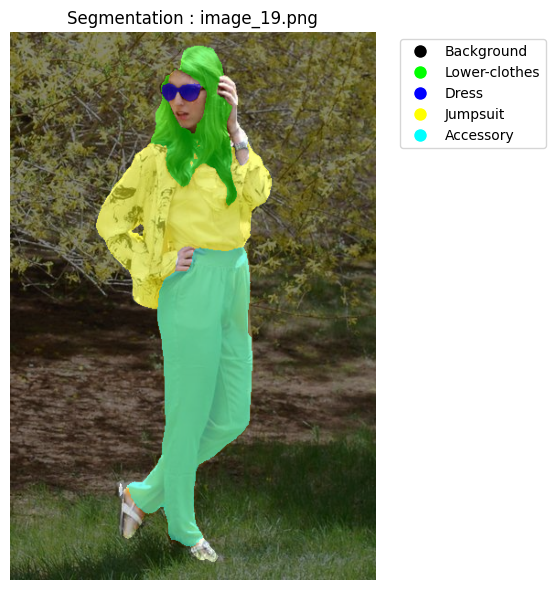

Processing image_2.png...


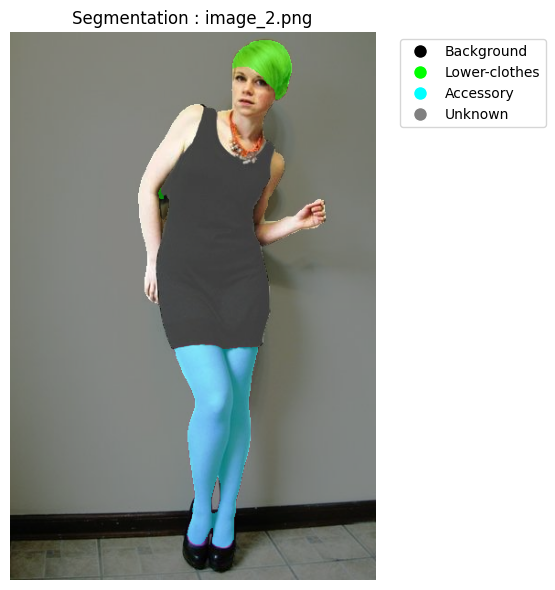

Processing image_20.png...


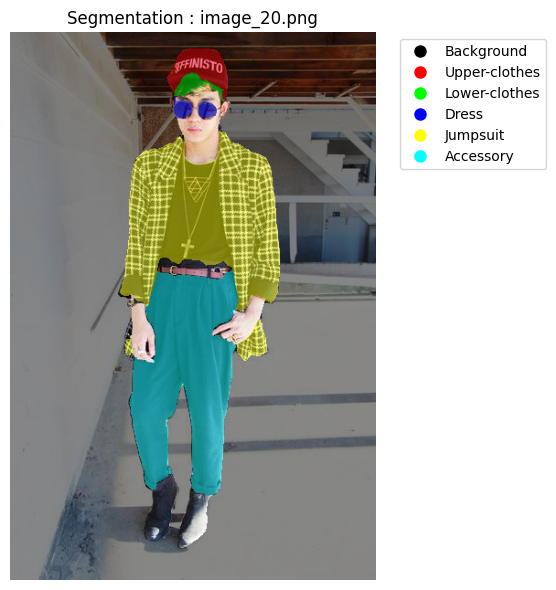

Processing image_21.png...


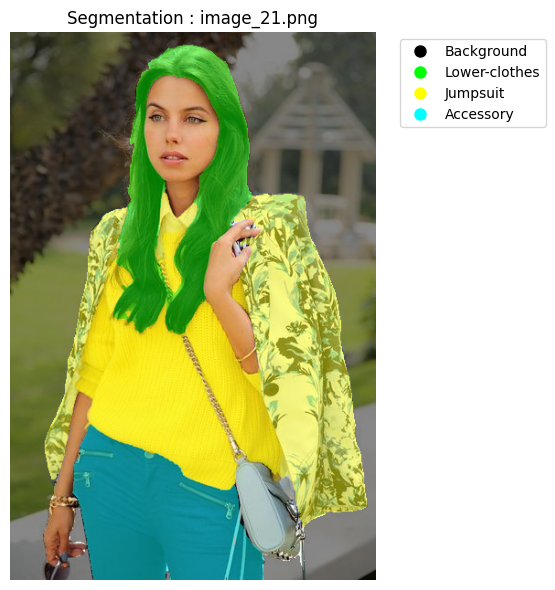

Processing image_22.png...


KeyboardInterrupt: 

In [17]:
folder_path = "assets/IMG"

# Boucle sur toutes les images du dossier
for filename in os.listdir(folder_path):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        print(f"Processing {filename}...")
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path).convert("RGB")

        # Prétraitement
        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits.cpu()

        # Redimension à la taille de l'image d'origine
        upsampled_logits = F.interpolate(
            logits,
            size=image.size[::-1],
            mode="bilinear",
            align_corners=False,
        )
        pred_seg = upsampled_logits.argmax(dim=1)[0].numpy()

        # Création d'un masque coloré avec transparence
        color_mask = np.zeros((*pred_seg.shape, 4), dtype=np.uint8)  # RGBA
        unique_classes = np.unique(pred_seg)

        for class_id in unique_classes:
            if class_id >= len(color_palette):
                continue
            color = color_palette[class_id]
            mask = pred_seg == class_id
            color_mask[mask] = (*color, 120)  # Alpha = 120/255 (transparence)

        # Fusion avec l'image d'origine
        image_np = np.array(image).astype(np.uint8)
        blended = Image.alpha_composite(
            Image.fromarray(image_np).convert("RGBA"),
            Image.fromarray(color_mask)
        )

        # Affichage avec légende
        plt.figure(figsize=(8, 6))
        plt.imshow(blended)
        handles = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=np.array(color_palette[c])/255, label=id2label[c],
                              markersize=10) for c in unique_classes if c in id2label]
        plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.axis("off")
        plt.title(f"Segmentation : {filename}")
        plt.tight_layout()
        plt.show()